# Coherence as a means to reconcile fringe transmission contrasts
In order of ascending contrast, we have found that the extended source fringes had the smallest contrast, followed by the point source fringes, followed then by the internal calibration source fringes. We do not take the etalon data into account here (which obviously have the largest contrast) given that an external etalon is used to produce the fringes. We are mainly interested by the fringes/interference caused by the MIRI detectors as such. As of yet it is not clear how the fringe contrast relates to the size of the source in the pupil plane. In fact if there exists such a trend, it is rather strange that the MTS extended source and the internal calibration (also extended) source do not look more similar in contrast. We saw however in Notebook 10 that the internal calibration source spectrum has spatial structure to it. This means that the source is resolved, or at least that it is less blurred out compared to the MTS extended source. Applying this to the fringes, these have more (or less) of an angle-averaging extent to them, thus they are less washed out for the internal calibration source compared to the MTS extended source. Let's see how this can be quantified.

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [1]:
# import modules
import funcs
import mrsobs

import numpy as np
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt
plt.style.use('presentation')
%matplotlib notebook

import warnings
warnings.simplefilter('ignore')

We load the images for one band of the MRS for different kinds of sources, including: 
* MTS 800K BB extended source
* MIRI 800K BB internal calibration source
* MTS 800K BB extended source observed through 100micron pinhole 
  
Additionally the pixel-to-wavelength calibration map and the pixel-to-along-slice position map are imported.

In [3]:
# Define paths to data
workDir   = '/Users/ioannisa/Desktop/python/miri_devel/'
cdpDir    = workDir+'cdp_data/'
d2cMapDir = workDir+'notebooks/distortionMaps/'
lvl2path  = workDir+'FM_data/LVL2/'

# Get data
band = '1B'
ext_source_sci,ext_source_bkg           = mrsobs.FM_MTS_BB_extended_source(lvl2path,band,bb_temp='800K')
intcal_source_sci                       = mrsobs.MIRI_internal_calibration_source(lvl2path,band,campaign='FM')
point_source_sci_p1,point_source_bkg_p1 = mrsobs.FM_MTS_800K_BB_MRS_OPT_06_raster(lvl2path,position='middle',pointing='P3')

# Get wavelength calibration pixel map
d2cMaps   = funcs.load_obj('d2cMaps_band{}_tr80pc'.format(band),path=d2cMapDir)
lambdaMap = d2cMaps['lambdaMap']
sliceMap  = d2cMaps['sliceMap']
nslices   = d2cMaps['nslices']

# Get spectral resolution table
specres_table = funcs.get_cdps(cdpDir=cdpDir,band=band)[4]

We subtract background exposures where available.

In [4]:
# perform transform
ext_source_bkgsubtr      = ext_source_sci-ext_source_bkg
point_source_p1_bkgsubtr = point_source_sci_p1-point_source_bkg_p1

We perform an even-odd row signal correction to the data (caused by the read-out pattern of MIRI detector pixel rows).

In [5]:
ext_source_oddevencorr      = funcs.OddEvenRowSignalCorrection(ext_source_bkgsubtr)
intcal_source_oddevencorr   = funcs.OddEvenRowSignalCorrection(intcal_source_sci)
point_source_p1_oddevencorr = funcs.OddEvenRowSignalCorrection(point_source_p1_bkgsubtr)

One thing we do notice however is that the trend of increasing fringe amplitude with longer wavelengths is shared in all spectra. If so, could it be that the "only thing" differentiating the MTS extended source fringe transmission from the internal calibration source fringe (for instance) be a geometric or optical angle-averaging effect? Let us start where we left off in Notebook 10.

In [6]:
# pixel trace
ypos_p,xpos_p   = funcs.detpixel_trace_compactsource(point_source_p1_oddevencorr,band,d2cMaps)

# signal normalization based on fringe profile
sel = (lambdaMap[ypos_p,xpos_p]!=0)
intcal_source_norm = funcs.norm_fringe(intcal_source_sci[ypos_p,xpos_p][sel],thres=0.,min_dist=6,k=3,ext=3)
ext_source_norm = funcs.norm_fringe(ext_source_oddevencorr[ypos_p,xpos_p][sel],thres=0.,min_dist=6,k=3,ext=3)

<IPython.core.display.Javascript object>


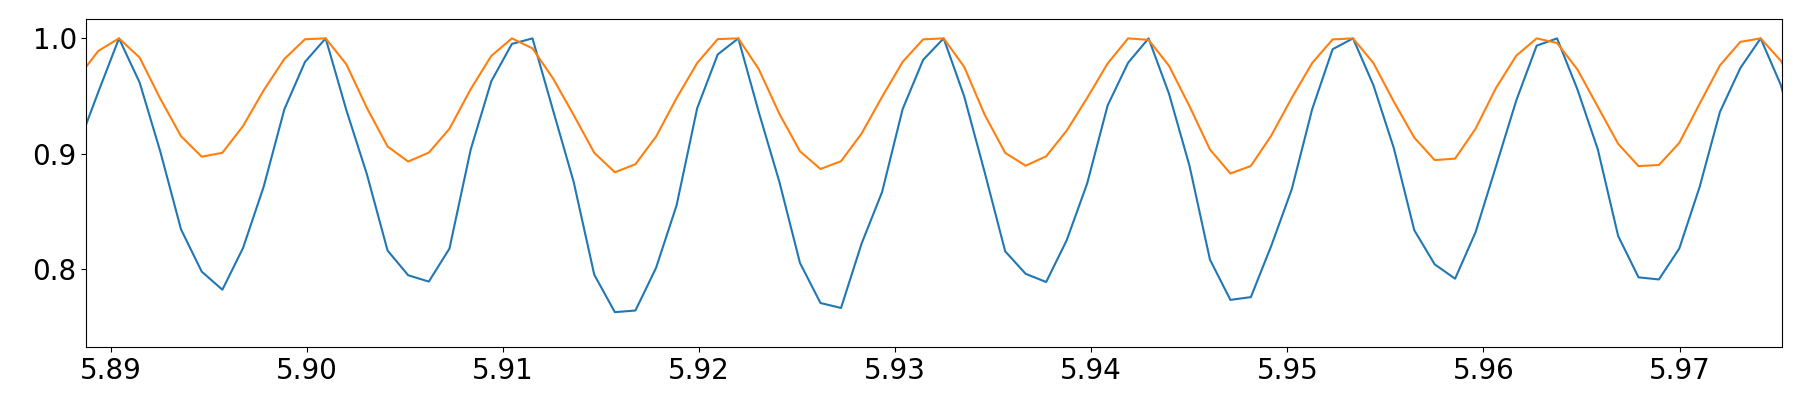

In [27]:
# plt.figure(figsize=(18,4))
# plt.plot(lambdaMap[ypos_p,xpos_p][sel],ext_source_norm[0])
# plt.plot(lambdaMap[ypos_p,xpos_p][sel][ext_source_norm[1]],ext_source_norm[0][ext_source_norm[1]],'ro')
# plt.plot(lambdaMap[ypos_p,xpos_p][sel],ext_source_norm[2])
# plt.tight_layout()

plt.figure(figsize=(18,4))
plt.plot(lambdaMap[ypos_p,xpos_p][sel],intcal_source_norm[0]/intcal_source_norm[2])
plt.plot(lambdaMap[ypos_p,xpos_p][sel],ext_source_norm[0]/ext_source_norm[2])
plt.tight_layout()

# fig,axs = plt.subplots(3,1,figsize=(12,13))
# axs[0].set_title('Internal Calibration Source spectrum')
# axs[0].plot(lambdaMap[ypos_p,xpos_p][sel],intcal_source_norm[0])
# axs[0].plot(lambdaMap[ypos_p,xpos_p][sel][intcal_source_norm[1]],intcal_source_norm[0][intcal_source_norm[1]],'ro')
# axs[0].plot(lambdaMap[ypos_p,xpos_p][sel],intcal_source_norm[2])
# # axs[0].set_ylim(350,830)
# axs[0].set_ylabel('Signal [DN/sec]')
# for plot in range(1,3):
#     axs[plot].plot(lambdaMap[ypos_p,xpos_p][sel],intcal_source_norm[0]/intcal_source_norm[2],label='Internal Calibration Source')
#     axs[plot].plot(lambdaMap[ypos_p,xpos_p][sel],ext_source_norm[0]/ext_source_norm[2],label='MTS Extended Source')
# #     axs[plot].hlines(1,4.88,5.77,linestyle='dashed')
#     axs[plot].set_ylim(0.7,1.05)
#     axs[plot].set_ylabel('Normalized signal')
# axs[1].legend(loc='upper right',bbox_to_anchor=(0.65,1.08),fontsize=10)
# # axs[2].hlines([0.795,0.912],4.88,5.77,'r',alpha=0.4,linestyle='dashed')
# axs[2].set_xlim(5.14,5.31)
# axs[2].set_title('<Zoomed view>')
# for plot in range(3): axs[plot].set_xlabel('Wavelength [micron]')
# plt.tight_layout()

In [20]:
wav = lambdaMap[ypos_p,xpos_p][sel]

<IPython.core.display.Javascript object>


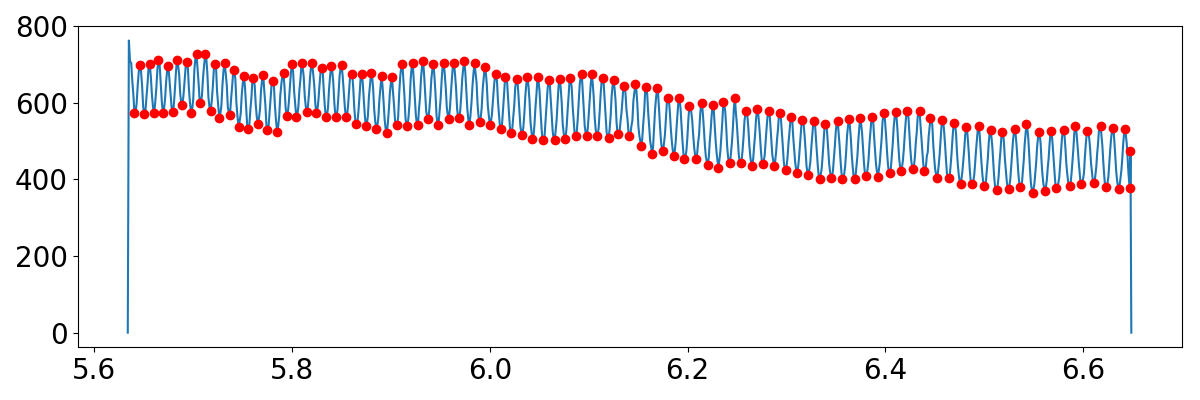

<IPython.core.display.Javascript object>


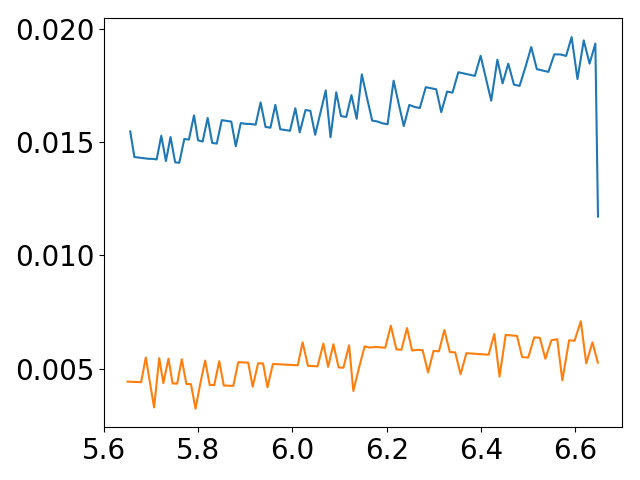

In [33]:
Absorp_0_norm_pos = funcs.norm_fringe(intcal_source_norm[0],min_dist=2)
Absorp_0_norm_neg = funcs.norm_fringe(-intcal_source_norm[0],min_dist=2)

plt.figure(figsize=(12,4))
plt.plot(wav,-Absorp_0_norm_neg[0])
plt.plot(wav[Absorp_0_norm_pos[1]],Absorp_0_norm_pos[0][Absorp_0_norm_pos[1]],'ro')
plt.plot(wav[Absorp_0_norm_neg[1]],-Absorp_0_norm_neg[0][Absorp_0_norm_neg[1]],'ro')
plt.tight_layout()

wav1,wav2,test1,test2 = [],[],[],[]
for i in range(1,len(Absorp_0_norm_pos[1])):
    test1.append(wav[Absorp_0_norm_pos[1]][i]-wav[Absorp_0_norm_neg[1]][i-1])
    test2.append(wav[Absorp_0_norm_neg[1]][i]-wav[Absorp_0_norm_pos[1]][i-1])
    wav1.append(wav[Absorp_0_norm_pos[1]][i])
    wav2.append(wav[Absorp_0_norm_neg[1]][i])

plt.figure()
plt.plot(wav1,test1)
plt.plot(wav2,test2)
plt.tight_layout()

<IPython.core.display.Javascript object>


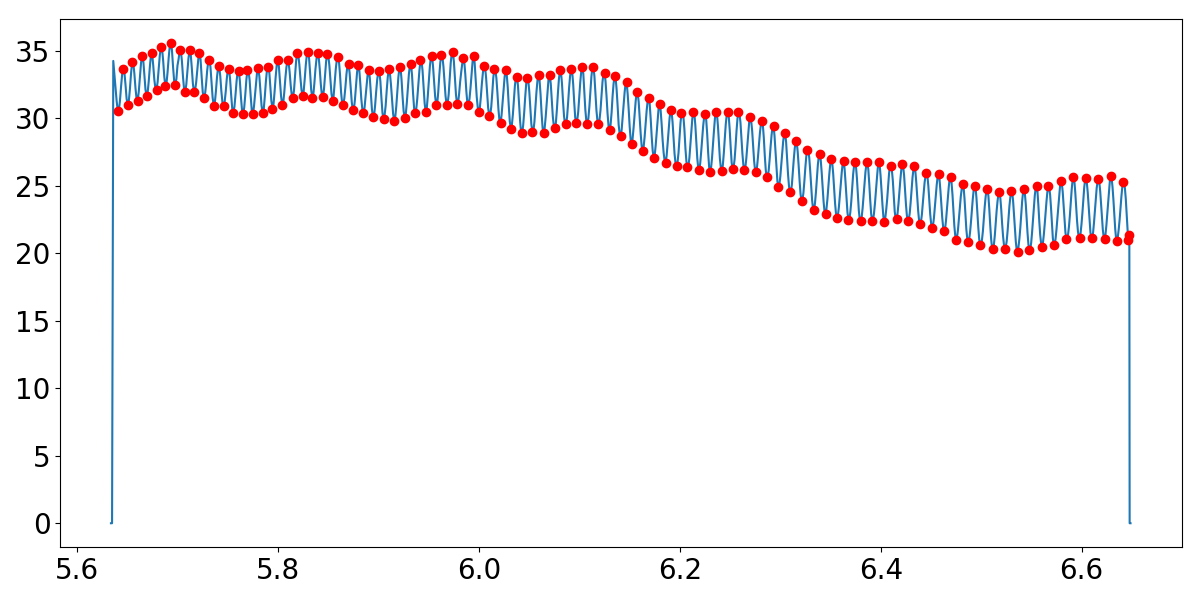

<IPython.core.display.Javascript object>


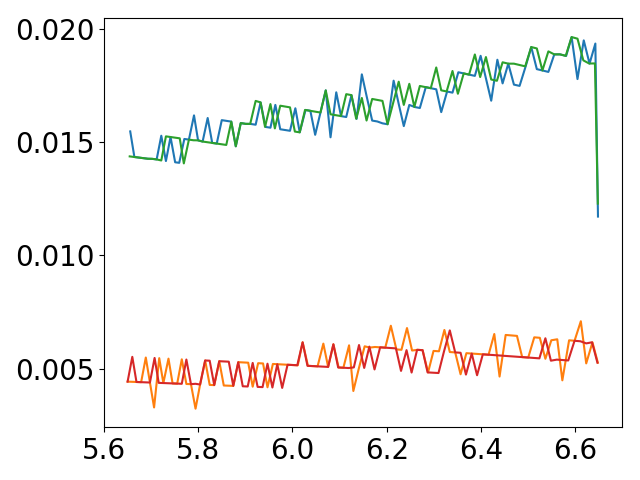

In [34]:
Absorp_0_norm_pos = funcs.norm_fringe(ext_source_norm[0],min_dist=2)
Absorp_0_norm_neg = funcs.norm_fringe(-ext_source_norm[0],min_dist=2)

plt.figure(figsize=(12,6))
plt.plot(wav,-Absorp_0_norm_neg[0])
plt.plot(wav[Absorp_0_norm_pos[1]],Absorp_0_norm_pos[0][Absorp_0_norm_pos[1]],'ro')
plt.plot(wav[Absorp_0_norm_neg[1]],-Absorp_0_norm_neg[0][Absorp_0_norm_neg[1]],'ro')
plt.tight_layout()

wav3,wav4,test3,test4 = [],[],[],[]
for i in range(1,len(Absorp_0_norm_pos[1])):
    test3.append(wav[Absorp_0_norm_pos[1]][i]-wav[Absorp_0_norm_neg[1]][i-1])
    test4.append(wav[Absorp_0_norm_neg[1]][i]-wav[Absorp_0_norm_pos[1]][i-1])
    wav3.append(wav[Absorp_0_norm_pos[1]][i])
    wav4.append(wav[Absorp_0_norm_neg[1]][i])

plt.figure()
plt.plot(wav1,test1)
plt.plot(wav2,test2)
plt.plot(wav3,test3)
plt.plot(wav4,test4)
plt.tight_layout()

### Test 1: Scanning the MTS extended and MIRI internal calibration source fringes
MTS extended source fringe scanning -->

In [24]:
# Compute zeroth order optical thickness of detector from fringe peak separation
ext_source_fringepeaks_wavelength     = lambdaMap[ypos_p,xpos_p][ext_source_norm[1]]       # microns
ext_source_fringepeaks_wavenumber     = np.flipud(10000./ext_source_fringepeaks_wavelength)       # cm-1
ext_source_mean_fringepeak_separation = np.mean(np.diff(ext_source_fringepeaks_wavenumber)[1:-1]) # omit first and last data point

ext_sel = np.nonzero(ext_source_norm[0])
ext_wavenumbers = np.flipud(10000./lambdaMap[ypos_p,xpos_p][ext_sel])
ext_norm_signal = np.flipud((ext_source_norm[0]/ext_source_norm[2])[ext_sel])

# define scanning window (arbitrarily set to 2*period)
N=1
while ext_wavenumbers[N]-ext_wavenumbers[0] < 2*ext_source_mean_fringepeak_separation: N+=1

# Scan fringes
ext_R,ext_D,ext_sigma_R,ext_sigma_D = [np.full(len(ext_wavenumbers),np.nan) for j in range(4)]

displacements = np.arange(-2,2,0.1) # um
len_numerics = []
for displacement in displacements:
    R0,D0 = 0.10,1/(2*ext_source_mean_fringepeak_separation) + displacement/10000.
    for i in range(len(ext_wavenumbers)-N):
        wvnr_segment = ext_wavenumbers[i: N+i].copy()
        array_segment  = ext_norm_signal[i: N+i].copy()

        # least-squares fitting
        try: 
            popt,pcov = curve_fit(funcs.FPfunc_noPhaseShift,wvnr_segment,array_segment,p0=(R0,D0),absolute_sigma=True,method='lm')
            ext_D[i: N+i] = popt[1]

        except RuntimeError: 
            continue
    len_numerics.append(len(np.where(np.abs(np.diff(ext_D))*10000.>1)[0]))
len_numerics = np.array(len_numerics)

R0,D0 = 0.10,1/(2*ext_source_mean_fringepeak_separation) + displacements[np.argmin(len_numerics)]/10000.
for i in range(len(ext_wavenumbers)-N):
    wvnr_segment = ext_wavenumbers[i: N+i].copy()
    array_segment  = ext_norm_signal[i: N+i].copy()

    # least-squares fitting
    try: 
        popt,pcov = curve_fit(funcs.FPfunc_noPhaseShift,wvnr_segment,array_segment,p0=(R0,D0),absolute_sigma=True,method='lm')
        TR = funcs.FPfunc_noPhaseShift(wvnr_segment,*popt)

        ext_R[i: N+i] = popt[0]
        ext_D[i: N+i] = popt[1]
        ext_sigma_R[i: N+i] = np.sqrt(np.diag(pcov))[0]
        ext_sigma_D[i: N+i] = np.sqrt(np.diag(pcov))[1]
        
    except RuntimeError: 
        continue
# take care about numerics!
if len_numerics[np.argmin(len_numerics)] != 0:
    ext_R,ext_D,numerics = funcs.cleanRD(ext_R,ext_D)

#> transmittance function
ext_TR = funcs.FPfunc_noPhaseShift(ext_wavenumbers,ext_R,ext_D)

<IPython.core.display.Javascript object>


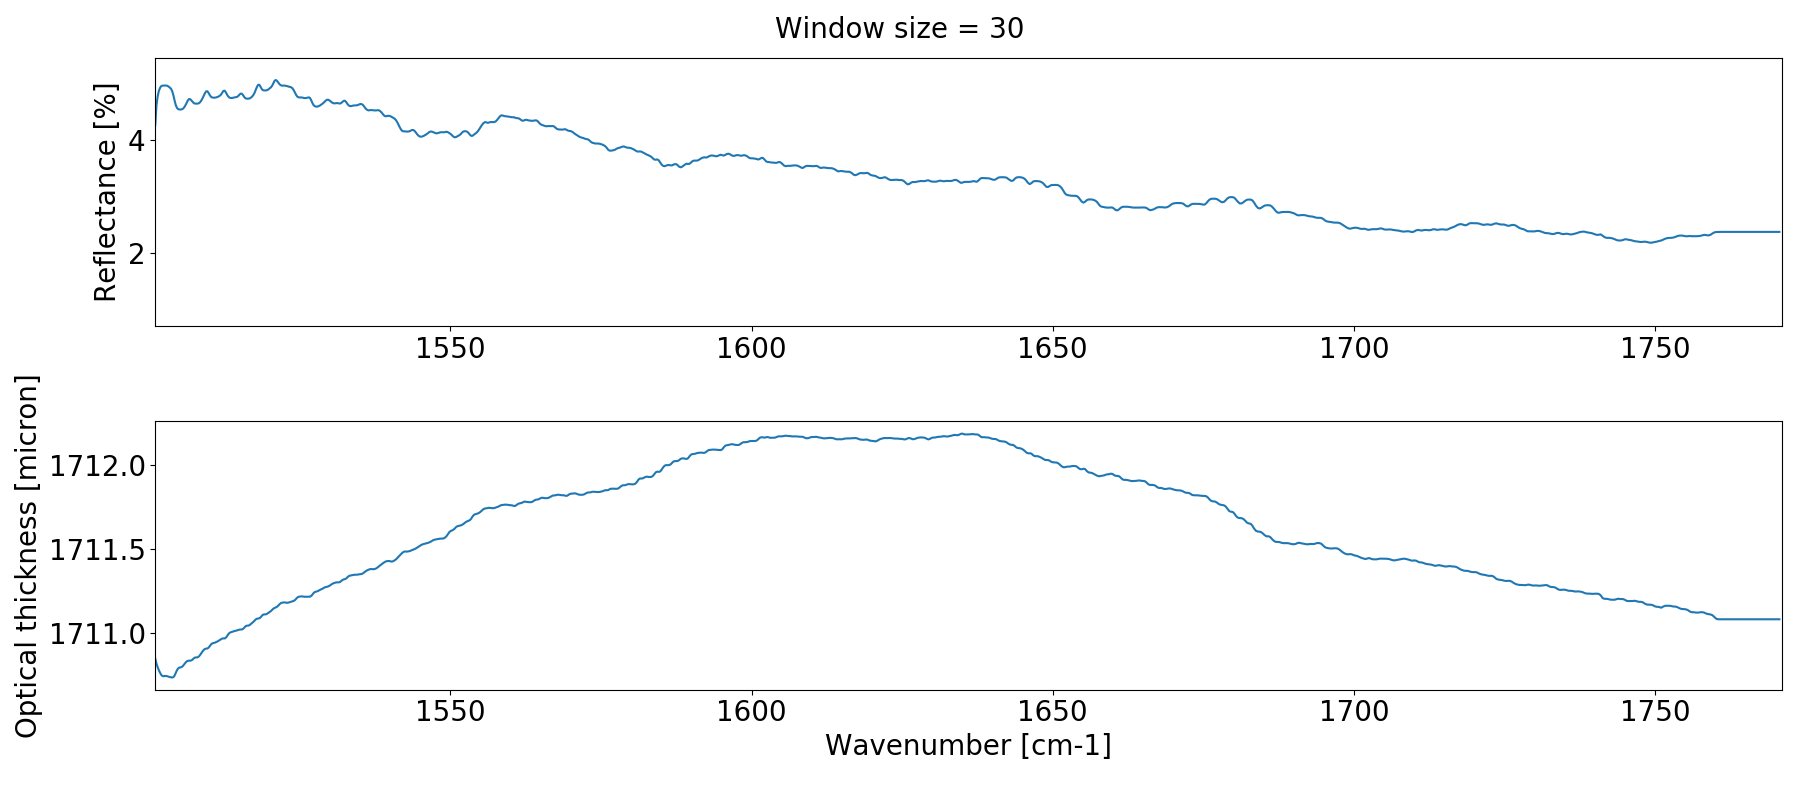

<IPython.core.display.Javascript object>


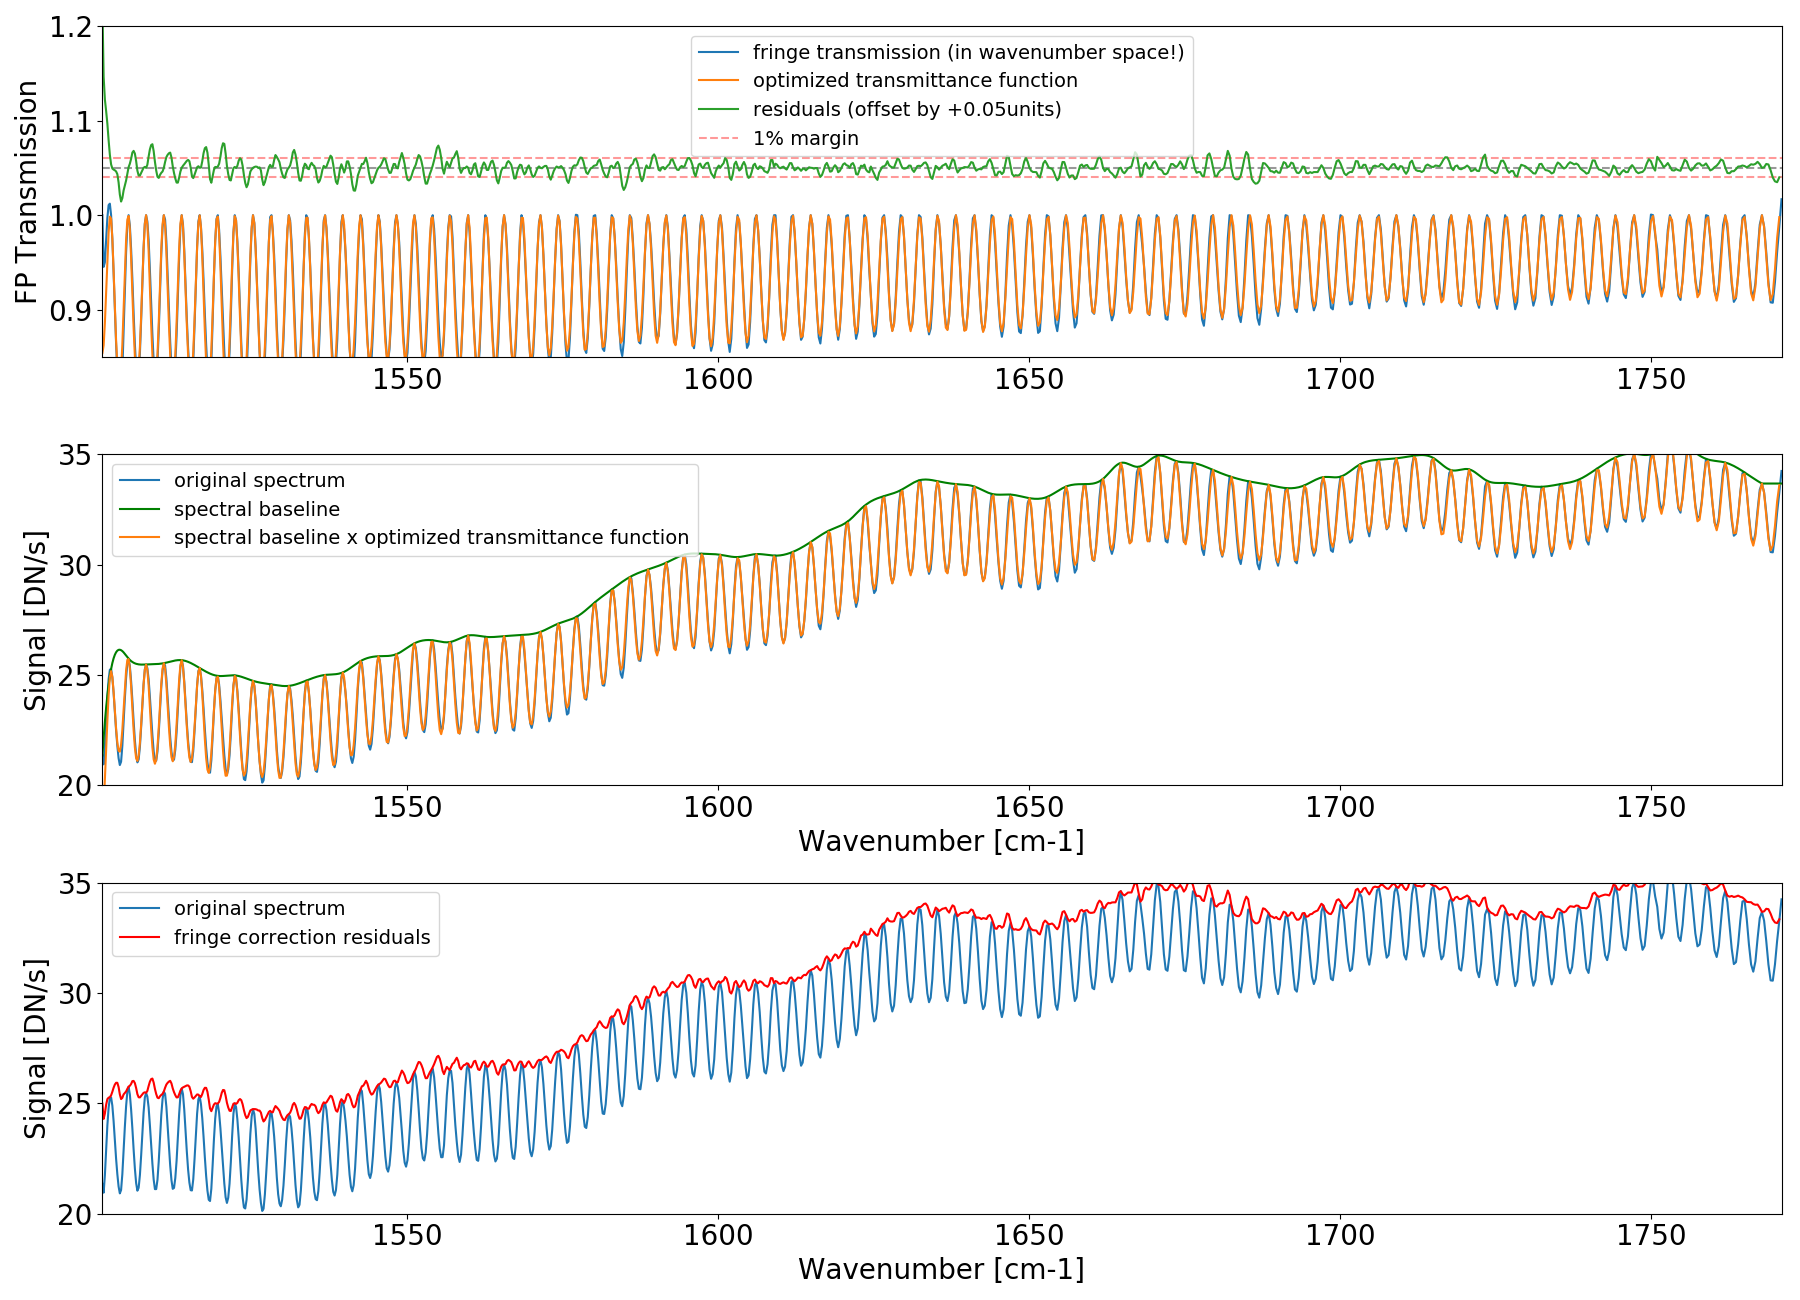

In [25]:
# let's look at the results
fig,axs = plt.subplots(2,1,figsize=(18,8))
axs[0].plot(ext_wavenumbers,ext_R*100.)
axs[0].set_xlim(ext_wavenumbers[0],ext_wavenumbers[-1])
axs[0].set_ylim(1.2,4)
axs[0].set_ylabel('Reflectance [%]')
axs[1].plot(ext_wavenumbers,ext_D*10000.)
if len_numerics[np.argmin(len_numerics)] != 0:
    axs[1].plot(ext_wavenumbers[numerics],ext_D[numerics]*10000,'ro',markersize=1,label='numerics')
axs[1].set_xlim(ext_wavenumbers[0],ext_wavenumbers[-1])
axs[1].set_ylabel('Optical thickness [micron]')
axs[1].set_xlabel('Wavenumber [cm-1]')
axs[1].legend()
plt.suptitle('Window size = {}'.format(N),fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.96])

# let's apply the optimized transmittance function as our "fringe correction"
fig,axs = plt.subplots(3,1,figsize=(18,13))
axs[0].plot(ext_wavenumbers,ext_norm_signal,label='fringe transmission (in wavenumber space!)')
axs[0].plot(ext_wavenumbers,ext_TR,label='optimized transmittance function')
axs[0].hlines(1.05,ext_wavenumbers[0],ext_wavenumbers[-1],alpha=0.4,linestyle='dashed')
axs[0].plot(ext_wavenumbers,ext_norm_signal/ext_TR +0.05,label='residuals (offset by +0.05units)')
axs[0].hlines([1.04,1.06],ext_wavenumbers[0],ext_wavenumbers[-1],'r',alpha=0.4,linestyle='dashed',label='1% margin')
axs[0].set_xlim(ext_wavenumbers[0],ext_wavenumbers[-1])
axs[0].set_ylim(0.85,1.2)
axs[0].set_ylabel('FP Transmission')
axs[0].legend(loc='upper center')
axs[1].plot(ext_wavenumbers,np.flipud(ext_source_norm[0][ext_sel]),label='original spectrum')
axs[1].plot(ext_wavenumbers,np.flipud(ext_source_norm[2][ext_sel]),'g',label='spectral baseline')
axs[1].plot(ext_wavenumbers,np.flipud(ext_source_norm[2][ext_sel])*ext_TR,label='spectral baseline x optimized transmittance function')
axs[1].set_ylim(20,35)
axs[1].set_xlim(ext_wavenumbers[0],ext_wavenumbers[-1])
axs[1].set_ylabel('Signal [DN/s]')
axs[2].plot(ext_wavenumbers,np.flipud(ext_source_norm[0][ext_sel]),label='original spectrum')
axs[2].plot(ext_wavenumbers,np.flipud(ext_source_norm[0][ext_sel])/ext_TR,'r',label='fringe correction residuals')
axs[2].set_xlim(ext_wavenumbers[0],ext_wavenumbers[-1])
axs[2].set_ylim(20,35)
axs[2].set_ylabel('Signal [DN/s]')
for plot in range(1,3): 
    axs[plot].set_xlabel('Wavenumber [cm-1]')
    axs[plot].legend(loc='upper left')
plt.tight_layout()

MIRI internal calibration source fringe scanning -->

In [26]:
# Compute zeroth order optical thickness of detector from fringe peak separation
intcal_source_fringepeaks_wavelength     = lambdaMap[ypos_p,xpos_p][intcal_source_norm[1]]       # microns
intcal_source_fringepeaks_wavenumber     = np.flipud(10000./intcal_source_fringepeaks_wavelength)       # cm-1
intcal_source_mean_fringepeak_separation = np.mean(np.diff(intcal_source_fringepeaks_wavenumber)[1:-1]) # omit first and last data point

intcal_sel = np.nonzero(intcal_source_norm[0])
intcal_wavenumbers = np.flipud(10000./lambdaMap[ypos_p,xpos_p][intcal_sel])
intcal_norm_signal = np.flipud((intcal_source_norm[0]/intcal_source_norm[2])[intcal_sel])

# define scanning window (arbitrarily set to 2*period)
N=1
while intcal_wavenumbers[N]-intcal_wavenumbers[0] < 2*intcal_source_mean_fringepeak_separation: N+=1

# Scan fringes
intcal_R,intcal_D,intcal_sigma_R,intcal_sigma_D = [np.full(len(intcal_wavenumbers),np.nan) for j in range(4)]

displacements = np.arange(-2,2,0.1) # um
len_numerics = []
for displacement in displacements:
    R0,D0 = 0.10,1/(2*intcal_source_mean_fringepeak_separation) + displacement/10000.
    for i in range(len(intcal_wavenumbers)-N):
        wvnr_segment = intcal_wavenumbers[i: N+i].copy()
        array_segment  = intcal_norm_signal[i: N+i].copy()

        # least-squares fitting
        try: 
            popt,pcov = curve_fit(funcs.FPfunc_noPhaseShift,wvnr_segment,array_segment,p0=(R0,D0),absolute_sigma=True,method='lm')
            intcal_D[i: N+i] = popt[1]

        except RuntimeError: 
            continue
    len_numerics.append(len(np.where(np.abs(np.diff(intcal_D))*10000.>1)[0]))
len_numerics = np.array(len_numerics)

R0,D0 = 0.10,1/(2*intcal_source_mean_fringepeak_separation) + displacements[np.argmin(len_numerics)]/10000.
for i in range(len(intcal_wavenumbers)-N):
    wvnr_segment = intcal_wavenumbers[i: N+i].copy()
    array_segment  = intcal_norm_signal[i: N+i].copy()

    # least-squares fitting
    try: 
        popt,pcov = curve_fit(funcs.FPfunc_noPhaseShift,wvnr_segment,array_segment,p0=(R0,D0),absolute_sigma=True,method='lm')
        TR = funcs.FPfunc_noPhaseShift(wvnr_segment,*popt)

        intcal_R[i: N+i] = popt[0]
        intcal_D[i: N+i] = popt[1]
        intcal_sigma_R[i: N+i] = np.sqrt(np.diag(pcov))[0]
        intcal_sigma_D[i: N+i] = np.sqrt(np.diag(pcov))[1]
        
    except RuntimeError: 
        continue
# take care about numerics!
if len_numerics[np.argmin(len_numerics)] != 0:
    intcal_R,intcal_D,numerics = funcs.cleanRD(intcal_R,intcal_D)

#> transmittance function
intcal_TR = funcs.FPfunc_noPhaseShift(intcal_wavenumbers,intcal_R,intcal_D)

<IPython.core.display.Javascript object>


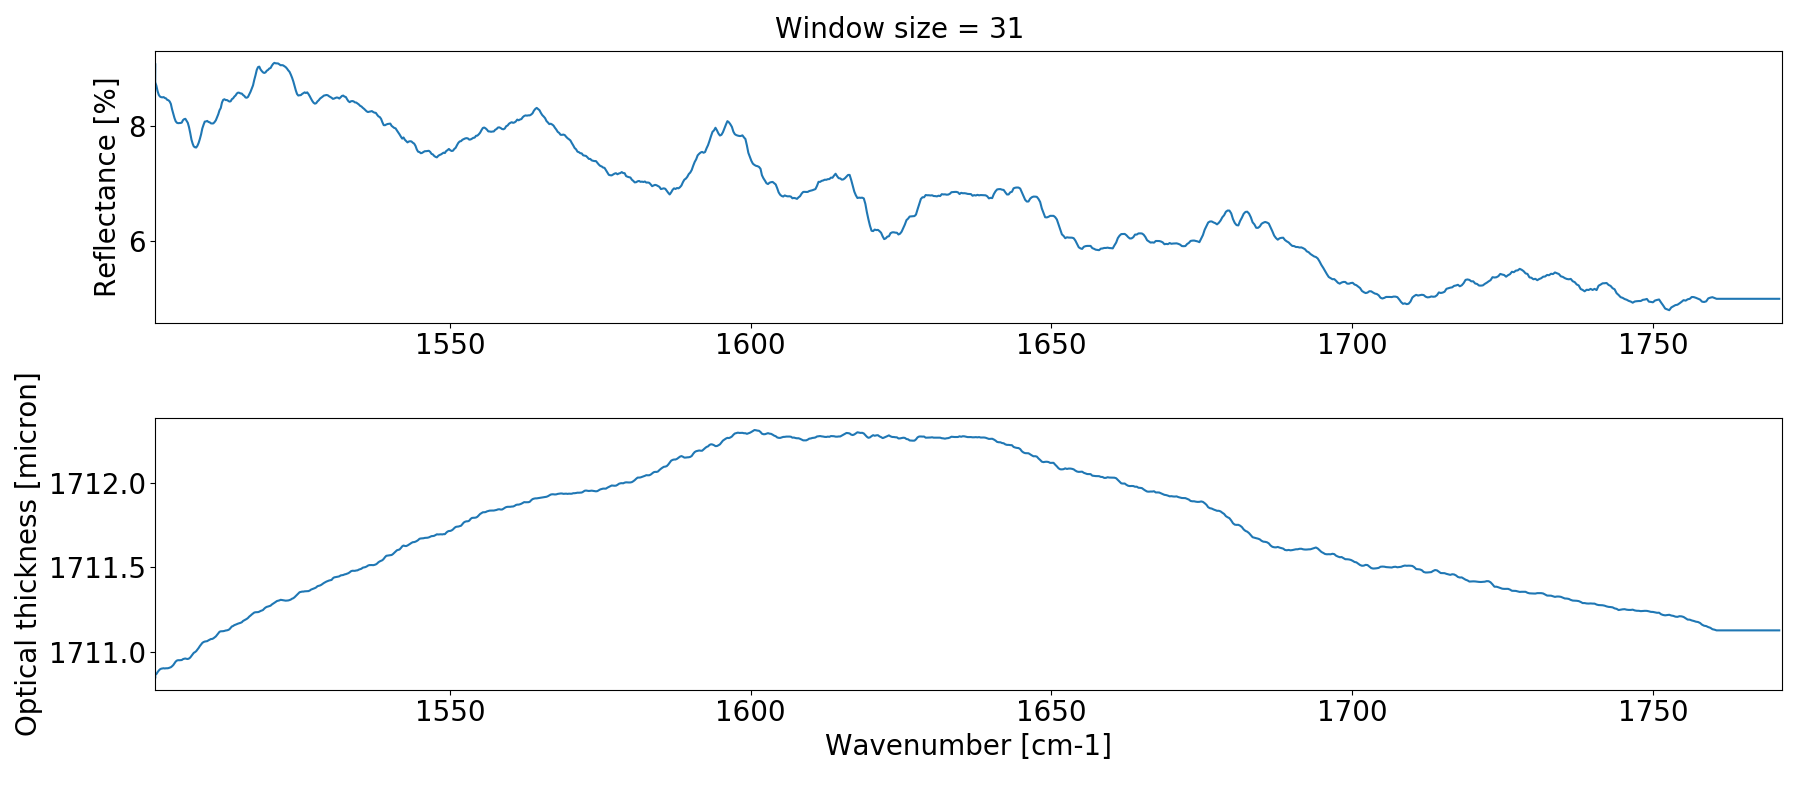

<IPython.core.display.Javascript object>


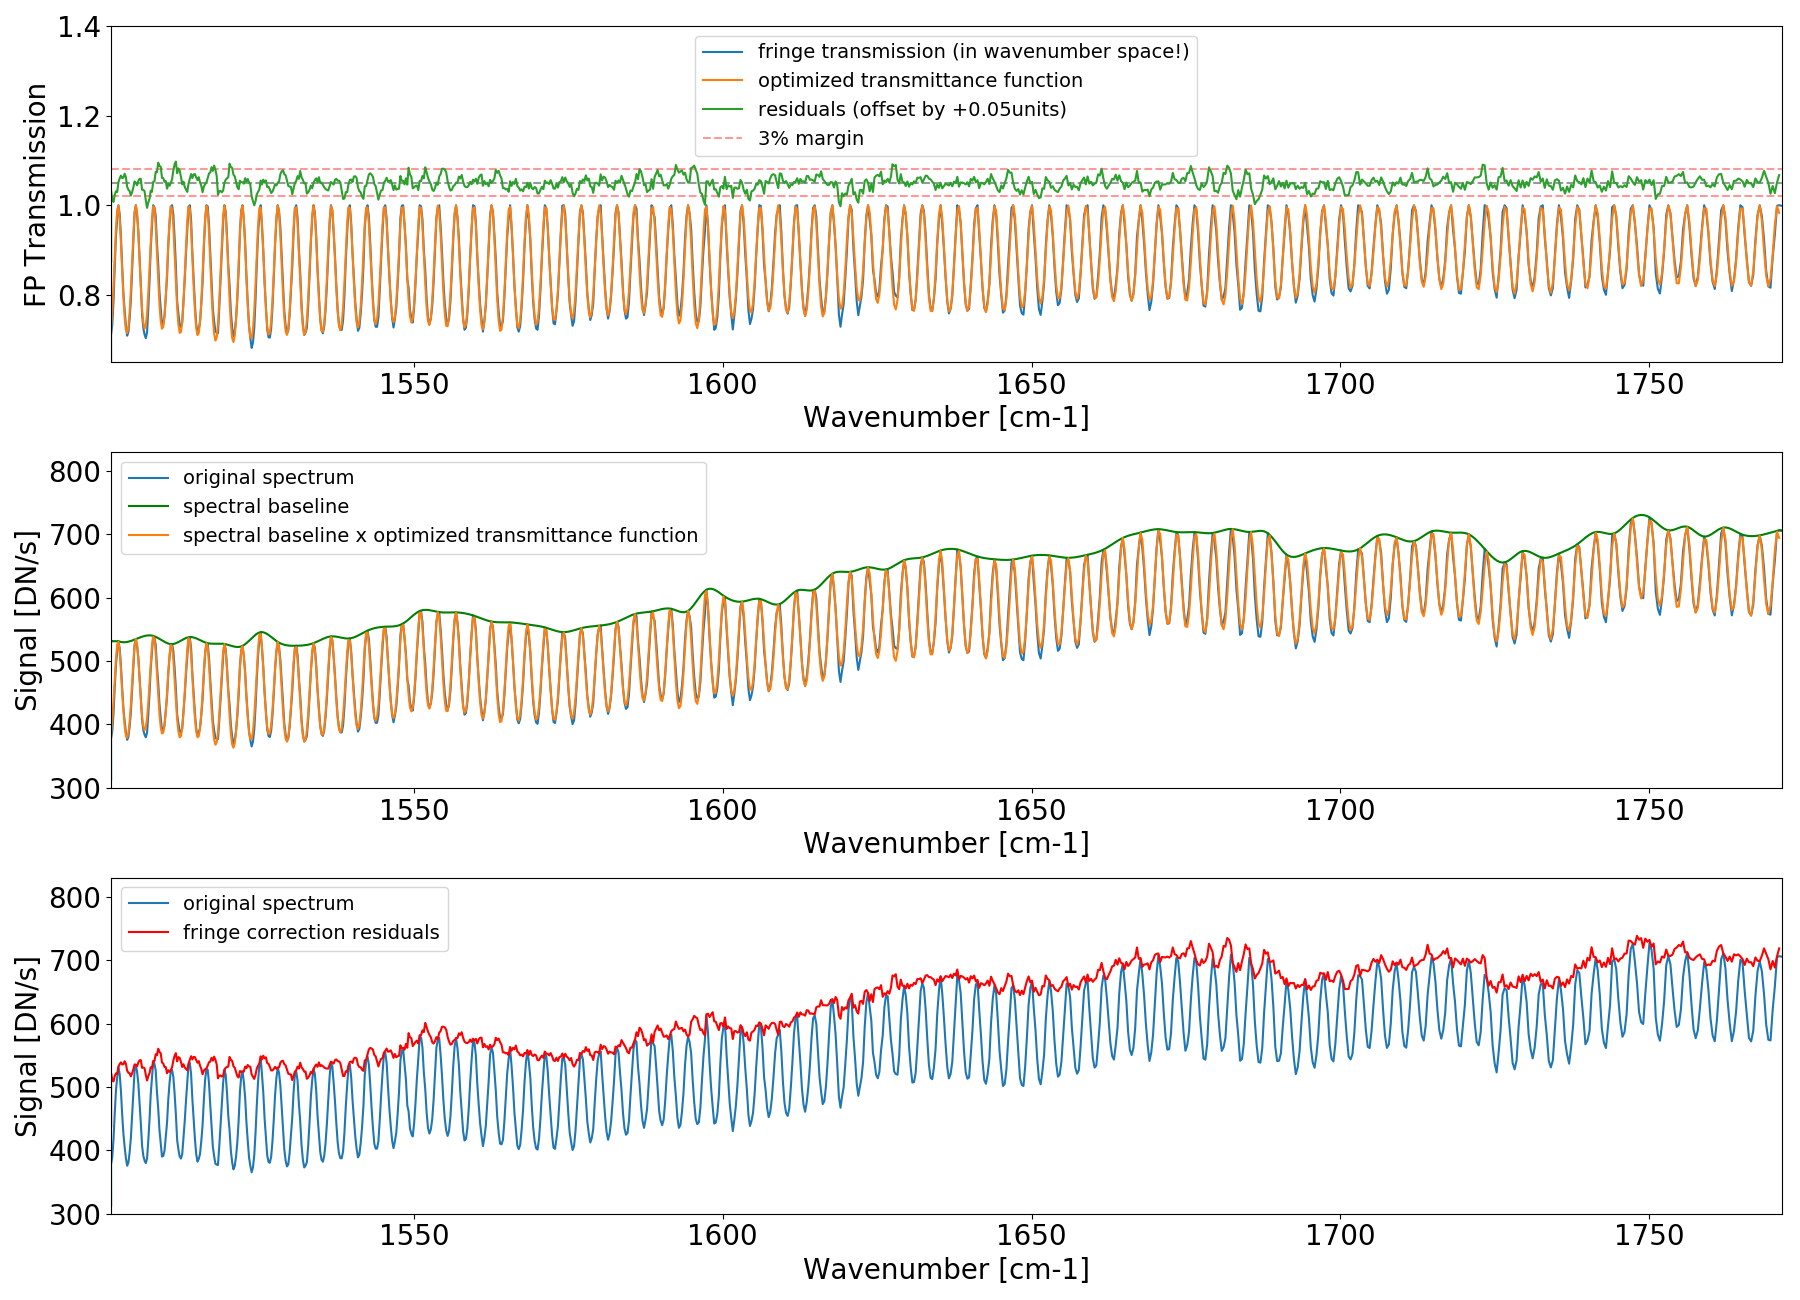

In [27]:
# let's look at the results
fig,axs = plt.subplots(2,1,figsize=(18,8))
axs[0].plot(intcal_wavenumbers,intcal_R*100.)
axs[0].set_xlim(intcal_wavenumbers[0],intcal_wavenumbers[-1])
# axs[0].set_ylim(1.2,4)
axs[0].set_ylabel('Reflectance [%]')
axs[1].plot(intcal_wavenumbers,intcal_D*10000.)
if len_numerics[np.argmin(len_numerics)] != 0:
    axs[1].plot(intcal_wavenumbers[numerics],intcal_D[numerics]*10000,'ro',markersize=1,label='numerics')
axs[1].set_xlim(intcal_wavenumbers[0],intcal_wavenumbers[-1])
axs[1].set_ylabel('Optical thickness [micron]')
axs[1].set_xlabel('Wavenumber [cm-1]')
axs[1].legend()
plt.suptitle('Window size = {}'.format(N),fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.96])

# let's apply the optimized transmittance function as our "fringe correction"
fig,axs = plt.subplots(3,1,figsize=(18,13))
axs[0].plot(intcal_wavenumbers,intcal_norm_signal,label='fringe transmission (in wavenumber space!)')
axs[0].plot(intcal_wavenumbers,intcal_TR,label='optimized transmittance function')
axs[0].hlines(1.05,intcal_wavenumbers[0],intcal_wavenumbers[-1],alpha=0.4,linestyle='dashed')
axs[0].plot(intcal_wavenumbers,intcal_norm_signal/intcal_TR +0.05,label='residuals (offset by +0.05units)')
axs[0].hlines([1.02,1.08],intcal_wavenumbers[0],intcal_wavenumbers[-1],'r',alpha=0.4,linestyle='dashed',label='3% margin')
axs[0].set_xlim(intcal_wavenumbers[0],intcal_wavenumbers[-1])
axs[0].set_ylim(0.65,1.4)
axs[0].set_xlabel('Wavenumber [cm-1]')
axs[0].set_ylabel('FP Transmission')
axs[0].legend(loc='upper center')
axs[1].plot(intcal_wavenumbers,np.flipud(intcal_source_norm[0][intcal_sel]),label='original spectrum')
axs[1].plot(intcal_wavenumbers,np.flipud(intcal_source_norm[2][intcal_sel]),'g',label='spectral baseline')
axs[1].plot(intcal_wavenumbers,np.flipud(intcal_source_norm[2][intcal_sel])*intcal_TR,label='spectral baseline x optimized transmittance function')
axs[1].set_ylim(300,830)
axs[1].set_xlim(intcal_wavenumbers[0],intcal_wavenumbers[-1])
axs[1].set_ylabel('Signal [DN/s]')
axs[2].plot(intcal_wavenumbers,np.flipud(intcal_source_norm[0][intcal_sel]),label='original spectrum')
axs[2].plot(intcal_wavenumbers,np.flipud(intcal_source_norm[0][intcal_sel])/intcal_TR,'r',label='fringe correction residuals')
axs[2].set_xlim(intcal_wavenumbers[0],intcal_wavenumbers[-1])
axs[2].set_ylim(300,830)
axs[2].set_ylabel('Signal [DN/s]')
for plot in range(1,3): 
    axs[plot].set_xlabel('Wavenumber [cm-1]')
    axs[plot].legend(loc='upper left')
plt.tight_layout()

Let's compare the optical properties derived from the MTS extended and the MIRI internal calibration source fringes.

<IPython.core.display.Javascript object>


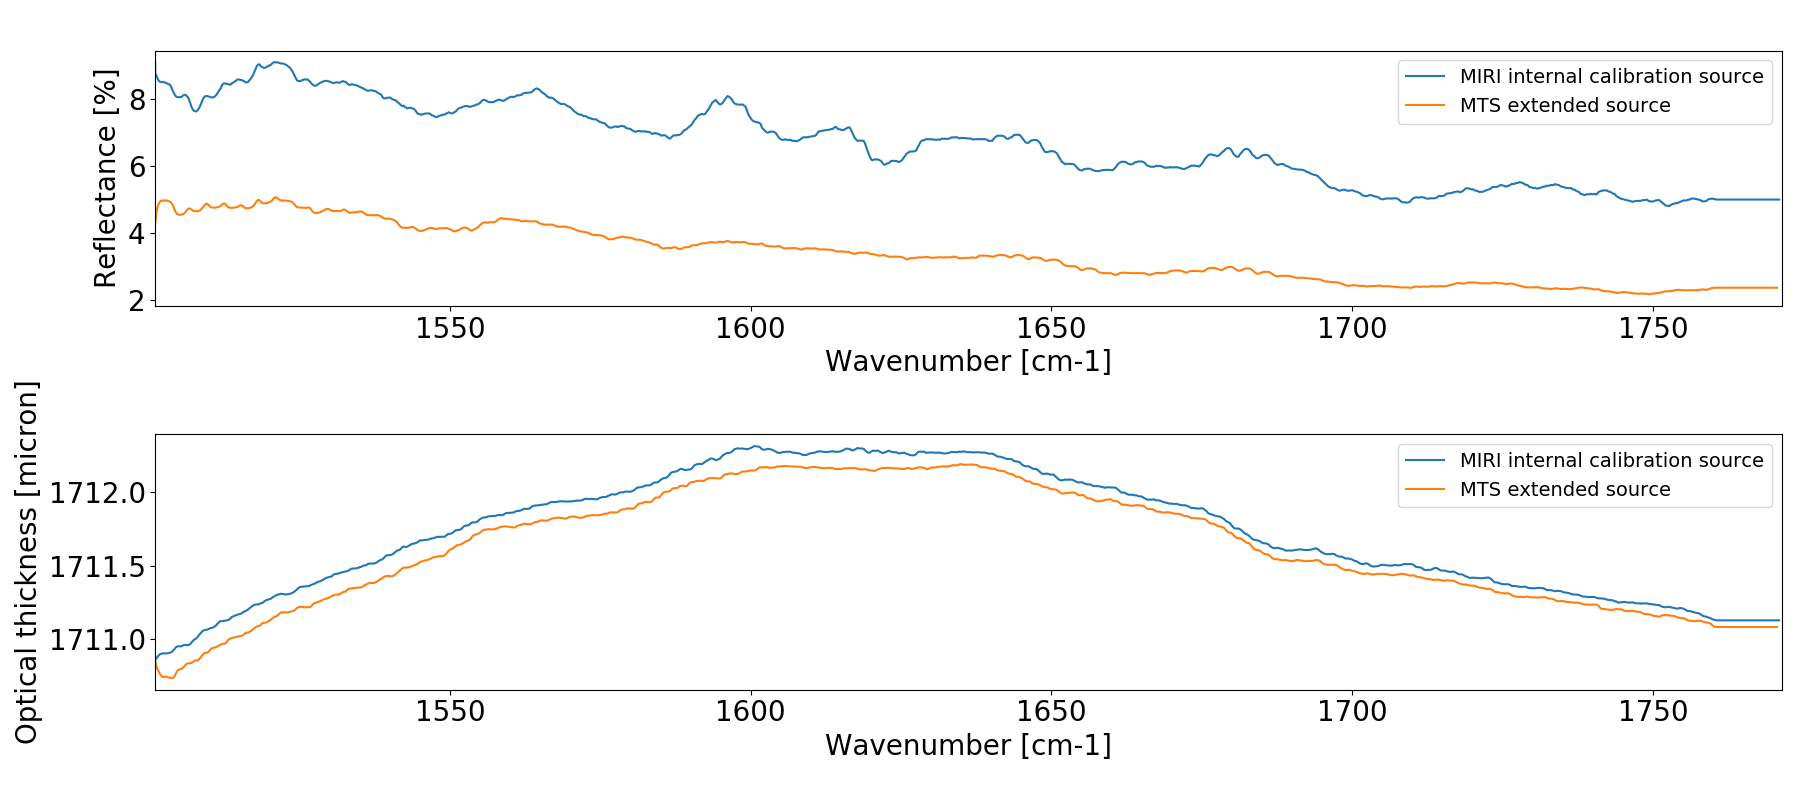

In [28]:
fig,axs = plt.subplots(2,1,figsize=(18,8))
axs[0].plot(intcal_wavenumbers,intcal_R*100.,label='MIRI internal calibration source')
axs[0].plot(ext_wavenumbers,ext_R*100.,label='MTS extended source')
axs[0].set_ylabel('Reflectance [%]')
axs[1].plot(intcal_wavenumbers,intcal_D*10000.,label='MIRI internal calibration source')
axs[1].plot(ext_wavenumbers,ext_D*10000.,label='MTS extended source')
axs[1].set_ylabel('Optical thickness [micron]')
for plot in range(2): 
    axs[plot].set_xlim(intcal_wavenumbers[0],intcal_wavenumbers[-1])
    axs[plot].set_xlabel('Wavenumber [cm-1]')
    axs[plot].legend()
plt.tight_layout(rect=[0, 0.03, 1, 0.96])

### Remarks:
* The two reflectance profiles appear to be correlated. It looks as though the reflectance determined from the MIRI internal calibration source is a scaled up version of the MTS extended source fringe reflectance. In fact there is a global factor 2.2 difference between the two, with smaller scale variations, that nevertheless look qualitatively similar.
* There seems to be a small difference in the optical thickness of the two fringes. This discrepancy becomes gradually larger at longer wavelengths (smaller wavenumbers). Could that be because of how the light from the MIRI internal calibration source is projected onto the gratings (compared to the light of the MTS extended source)? I.e. are we looking at a wavelength solution difference?

### Test 2: Re-derive the model fringe transmissions based on the optical thickness discrepancy
We know that the wavelength solution is consistent from analyzing etalon data. As such, the discrepancy in the optical thickness must be caused by a geometric effect on the optics of the MIRI internal calibration source illumination. Based on that conjecture we use the optical thickness determined from the MTS extended source fringes as the optical thickness of the MIRI internal calibration source fringe transmission.

In [29]:
intcal_detector_R,intcal_detector_D = np.full(1024,np.nan),np.full(1024,np.nan)
ext_detector_R,ext_detector_D       = np.full(1024,np.nan),np.full(1024,np.nan)

intcal_detector_R[intcal_sel],intcal_detector_D[intcal_sel] = np.flipud(intcal_R),np.flipud(intcal_D)
ext_detector_R[ext_sel],ext_detector_D[ext_sel] = np.flipud(ext_R),np.flipud(ext_D)

#> transmittance function
wavenumbers = np.flipud(10000./lambdaMap[ypos_p,xpos_p])
intcal_detector_TR = funcs.FPfunc_noPhaseShift(wavenumbers,np.flipud(intcal_detector_R),np.flipud(ext_detector_D) )
ext_detector_TR = funcs.FPfunc_noPhaseShift(wavenumbers,np.flipud(ext_detector_R),np.flipud(ext_detector_D) )

<IPython.core.display.Javascript object>


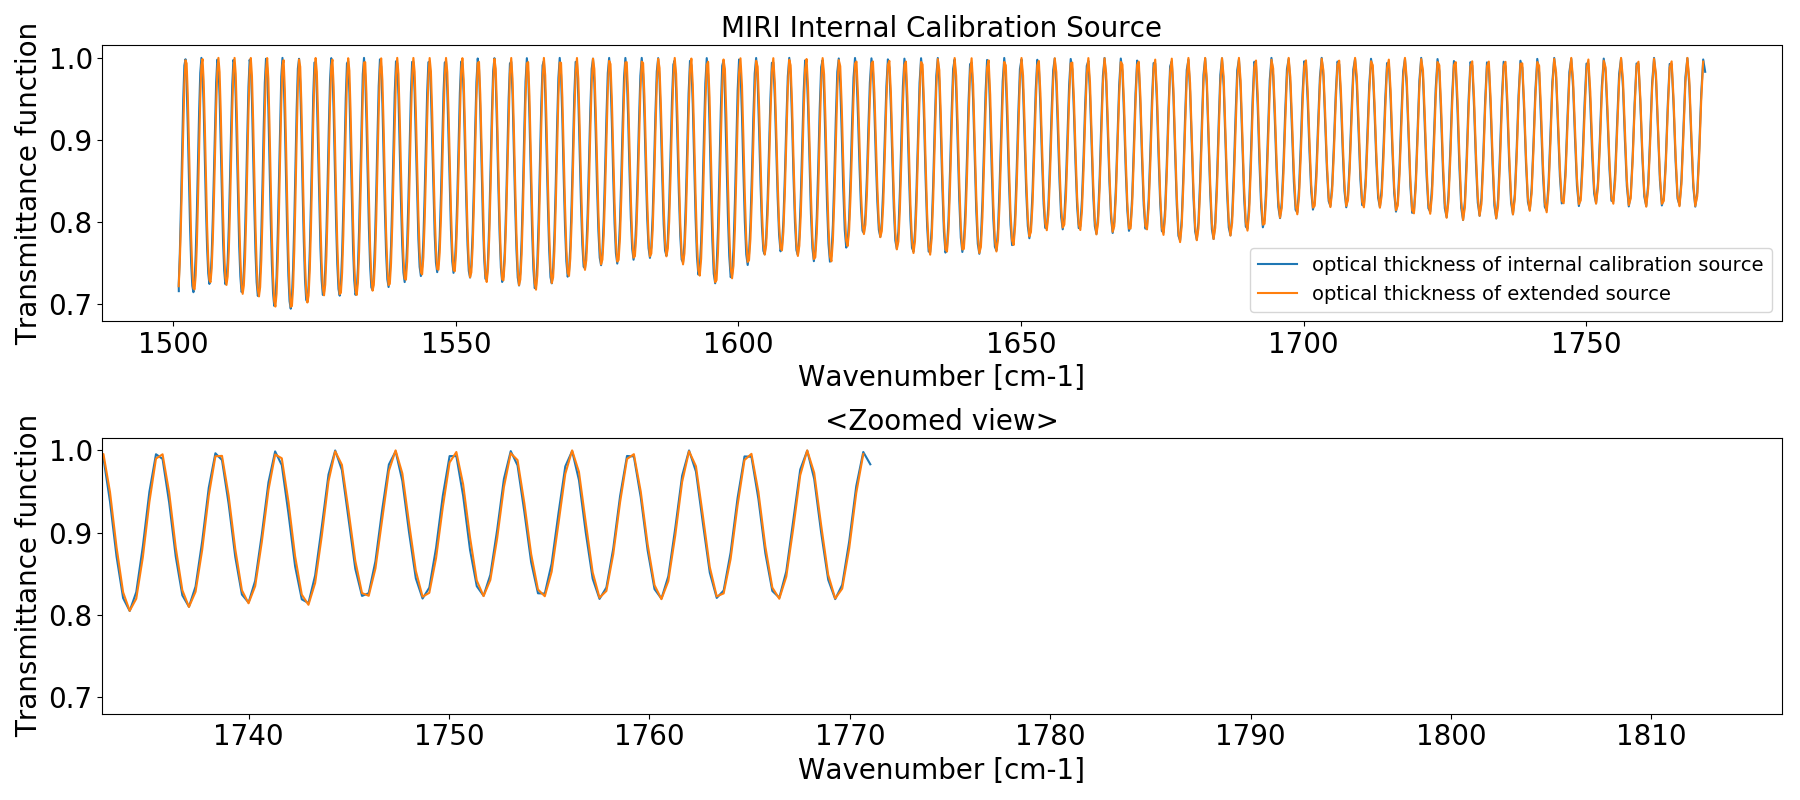

In [30]:
fig,axs = plt.subplots(2,1,figsize=(18,8))
axs[0].set_title('MIRI Internal Calibration Source')
for plot in range(2):
    axs[plot].plot(intcal_wavenumbers,intcal_TR,label='optical thickness of internal calibration source')
    axs[plot].plot(wavenumbers,intcal_detector_TR,label='optical thickness of extended source')
    axs[plot].set_xlabel('Wavenumber [cm-1]')
    axs[plot].set_ylabel('Transmittance function')
axs[1].set_xlim(1732.7,1816.5)
axs[1].set_title('<Zoomed view>')
axs[0].legend(loc='lower right')
plt.tight_layout()

### Test 3: Phase-averaging the internal calibration source fringes
The contrast of the internal calibration source fringes is much higher than that of the extended source fringes. Contrast can be reduced when averaging the fringe transmission over a range of phases. Let's see how this impacts the derived transmittance fuction of the internal calibration source fringes.

To apply the phase-averaging we:  
1. take a random value $Rand$ between -1 and +1 from a uniform distribution  
2. multiply the random value by the angle $\beta$
3. determine a transmittance function by including the random phase shift $\beta \cdot Rand$
4. repeat the process a number of times and average the resulting transmittance functions
  
After doing so we normalize the transmittance functions to the fringe peaks and compare the results.

<IPython.core.display.Javascript object>


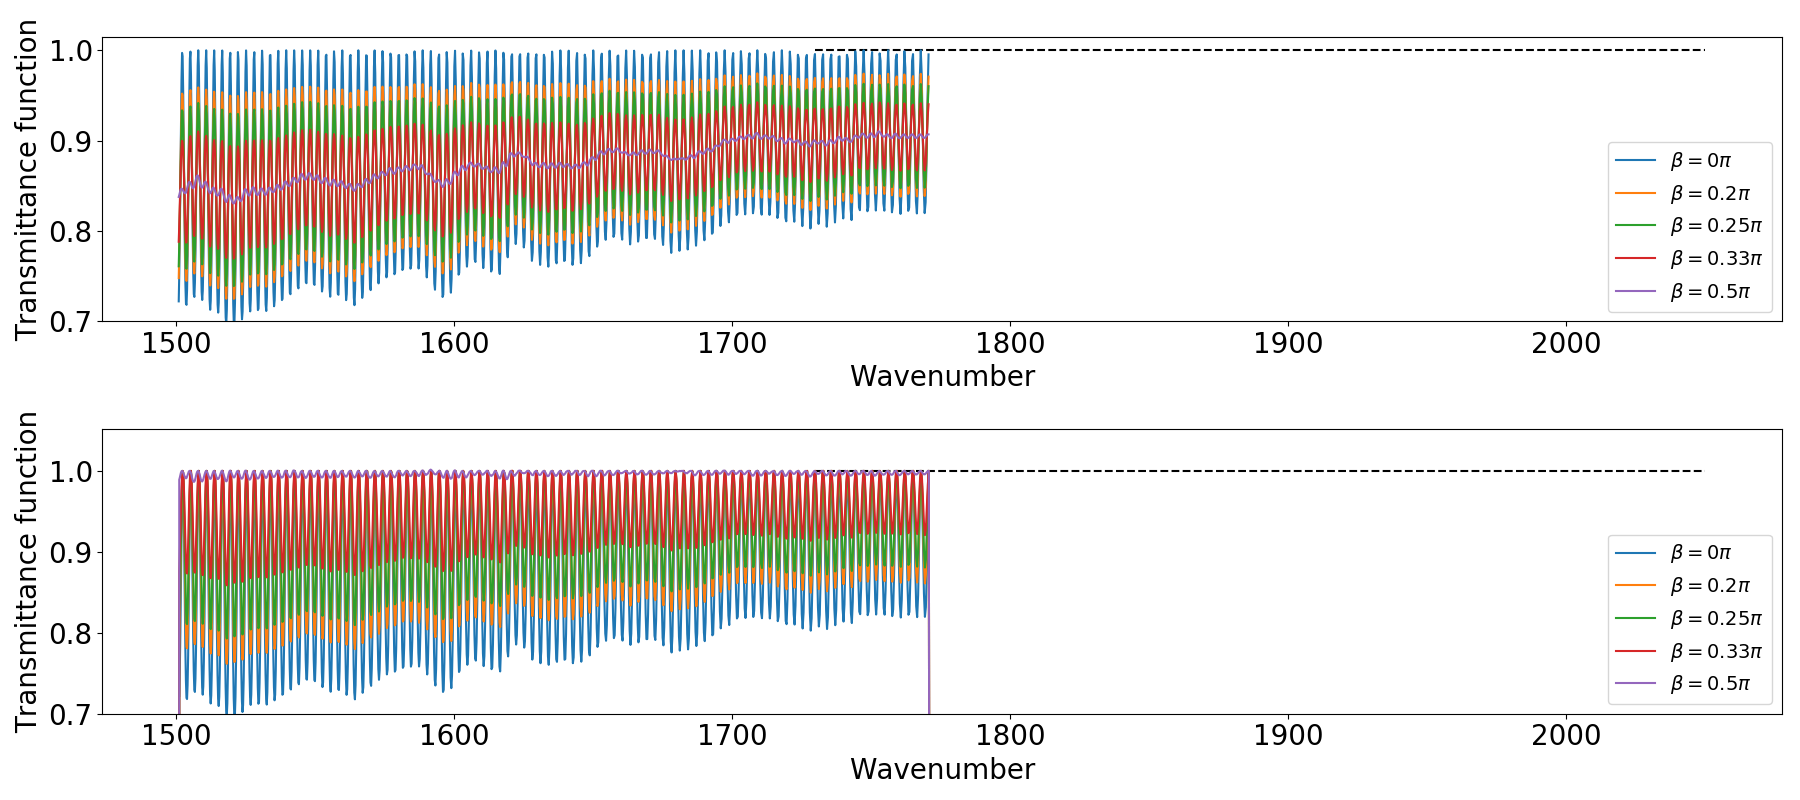

In [31]:
fig,axs = plt.subplots(2,1,figsize=(18,8))
for plot in range(2): 
    axs[plot].plot(wavenumbers,intcal_detector_TR,label=r'$\beta = 0\pi$')
for beta in [np.pi/5,np.pi/4,np.pi/3,np.pi/2.]:
    intcal_detector_TR_phase_avg = 0
    for rand in np.random.uniform(-1.,1.,5000):
        intcal_detector_TR_phase_avg += funcs.FPfunc(wavenumbers,np.flipud(intcal_detector_R),np.flipud(ext_detector_D),np.pi + beta*rand)
    intcal_detector_TR_phase_avg /= 5000.
    axs[0].plot(wavenumbers,intcal_detector_TR_phase_avg,label=r'$\beta = {} \pi$'.format(round(beta/np.pi,2)))
    # normalize fringes
    intcal_detector_TR_phase_avg_norm = funcs.norm_fringe(intcal_detector_TR_phase_avg,thres=0.,min_dist=2,k=3,ext=3)
    axs[1].plot(wavenumbers,intcal_detector_TR_phase_avg_norm[0]/intcal_detector_TR_phase_avg_norm[2],label=r'$\beta = {} \pi$'.format(round(beta/np.pi,2)))
for plot in range(2): 
    axs[plot].hlines(1,1730,2050,linestyle='dashed')
    axs[plot].set_ylim(0.70)
    axs[plot].legend(loc='lower right')
    axs[plot].set_xlabel('Wavenumber')
    axs[plot].set_ylabel('Transmittance function')
plt.tight_layout()

### Remarks:
* Averaging over a range of phases decreases the contrast of the fringes but also decreases the spectral continuum. Re-normalizing the transmittance functions based on the fringe peaks returns a normalized image of the problem, however this also conveys an important message. Phase-averaging is equivalent to "losing" the true spectral continuum. In the case of no phase-averaging the continuum was at a value of 1. After phase-averaging using $\beta=0.2\pi$ the continuum lowered by 3%, and for $\beta=0.5\pi$ the continuum lowered by 11%.
* In interference terms, a value $\beta = 0\pi$ implies fully coherent interference, a value $\beta = \pi$ implies fully incoherent interference (complete loss of wave phase information), and if $0 < \beta < \pi$ we have partial coherence.
* One way to get partial coherence is by:
    * introducing an instrumental resolution (wavelength binning)
    * averaging over a range of incidence angles
    * averaging over a cone angle, if the source is not in focus on the detector (such as for the MTS sources, which are of course not positioned at infinity as in the case of celestial targets)
    * getting interference in a cavity with atom impurities, such as the MIRI detector active layer.
  
It is not clear if one, two, three, or all four reasons above have an appreciable effect in the case of MIRI and the ground test observations. But let's compare the phase-averaged internal calibration source transmittance function to that of the MTS extended source. A $\chi^2$-minimization is carried out to determine the value of $\beta$ that minimizes the difference between the two fringe transmissions.

In [32]:
# determine partial coherence beta factor by minimizing difference between angle-averaged FP model and extended source data
betas = np.linspace(0,np.pi/2.,200)
# perform chi-square minimization
chi_square = []
for beta in betas:
    intcal_detector_TR_phase_avg = 0
    for rand in np.random.uniform(-1.,1.,1000):
        intcal_detector_TR_phase_avg += funcs.FPfunc(wavenumbers,np.flipud(intcal_detector_R),np.flipud(ext_detector_D),np.pi + beta*rand)
    intcal_detector_TR_phase_avg /= 1000.

    intcal_detector_TR_phase_avg_norm = funcs.norm_fringe(intcal_detector_TR_phase_avg,thres=0.,min_dist=2,k=3,ext=3)
    
    chi_square.append(np.sum(ext_detector_TR[~np.isnan(ext_detector_TR)]/(intcal_detector_TR_phase_avg_norm[0]/intcal_detector_TR_phase_avg_norm[2])[~np.isnan(ext_detector_TR)] -1 )**2)
beta = betas[np.argmin(np.array(chi_square))]

print r'Minimum chi^2 = {}'.format(round(np.min(np.array(chi_square)),5) )
print r'chi^2 minimized for beta = {} rad'.format(round(beta,4)) # radians
print r'chi^2 minimized for beta = {} pi rad'.format(round(beta/np.pi,2)) # radians
print r'chi^2 minimized for beta = {} deg'.format(round(beta*180./np.pi,4)) # degrees

Minimum chi^2 = 0.01009
chi^2 minimized for beta = 0.9235 rad
chi^2 minimized for beta = 0.29 pi rad
chi^2 minimized for beta = 52.9146 deg


<IPython.core.display.Javascript object>


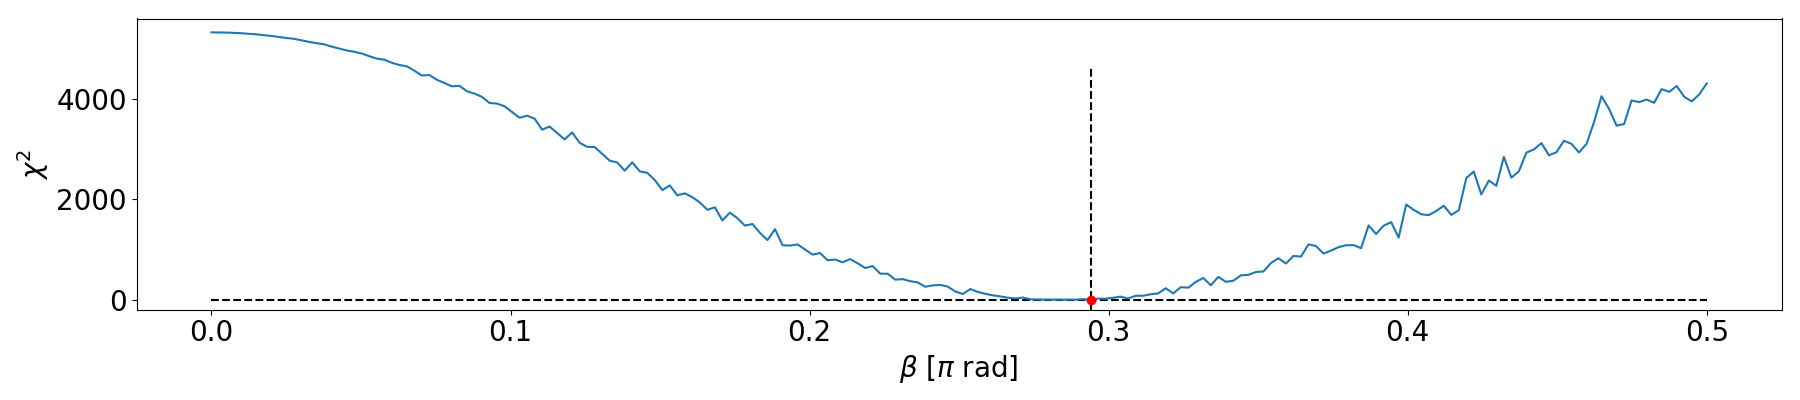

In [33]:
plt.figure(figsize=(18,4))
plt.plot(betas/np.pi,chi_square)
plt.plot(beta/np.pi,np.min(np.array(chi_square)),'ro')
plt.hlines(np.min(np.array(chi_square)),0,0.5,linestyle='dashed')
plt.vlines(beta/np.pi,-200,4650,linestyle='dashed')
plt.ylim(-200)
plt.xlabel(r'$\beta$ [$\pi$ rad]',fontsize=20)
plt.ylabel(r'$\chi^2$',fontsize=20)
plt.tick_params(axis='both',labelsize=20)
plt.tight_layout()

In [34]:
intcal_detector_TR_phase_avg = 0
for rand in np.random.uniform(-1.,1.,5000):
    intcal_detector_TR_phase_avg += funcs.FPfunc(wavenumbers,np.flipud(intcal_detector_R),np.flipud(ext_detector_D),np.pi + beta*rand)
intcal_detector_TR_phase_avg /= 5000.

# normalize fringes
intcal_detector_TR_phase_avg_norm = funcs.norm_fringe(intcal_detector_TR_phase_avg,thres=0.,min_dist=2,k=3,ext=3)

<IPython.core.display.Javascript object>


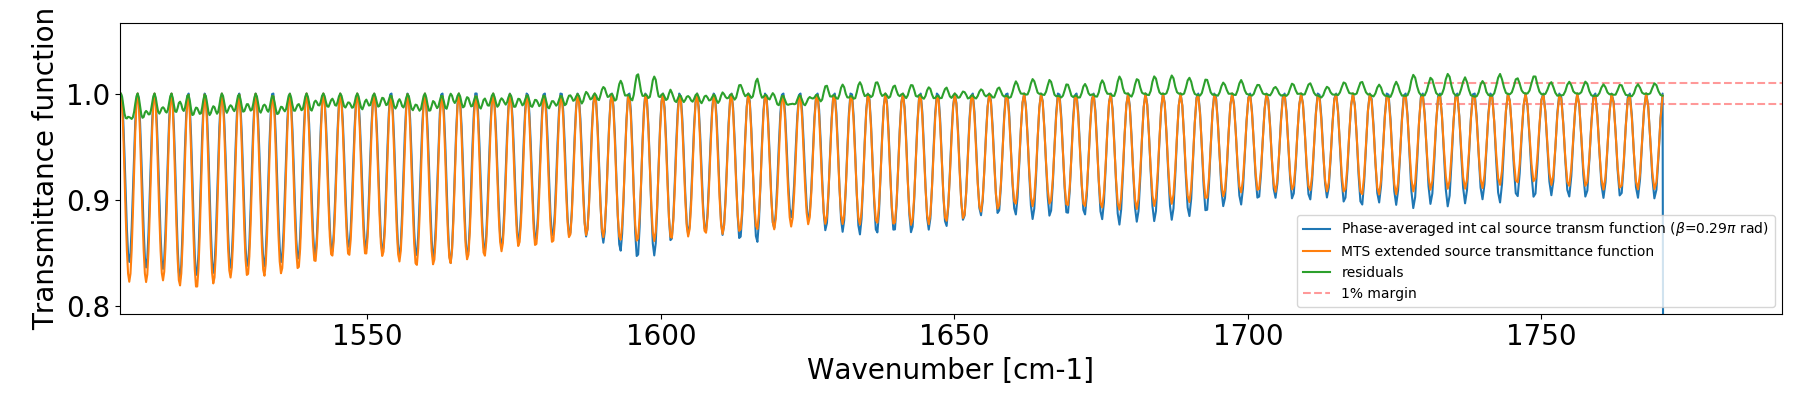

In [35]:
plt.figure(figsize=(18,4))
plt.plot(wavenumbers,(intcal_detector_TR_phase_avg_norm[0]/intcal_detector_TR_phase_avg_norm[2]),label=r'Phase-averaged int cal source transm function ($\beta$={}$\pi$ rad)'.format(round(beta/np.pi,2) ))
plt.plot(wavenumbers,ext_detector_TR,label='MTS extended source transmittance function')
plt.plot(wavenumbers,ext_detector_TR/(intcal_detector_TR_phase_avg_norm[0]/intcal_detector_TR_phase_avg_norm[2]),label='residuals')
plt.hlines([0.99,1.01],1730,2050,'r',linestyle='dashed',alpha=0.4,label='1% margin')
plt.ylim(0.85,1.03)
plt.xlabel('Wavenumber [cm-1]')
plt.ylabel('Transmittance function')
plt.legend(fontsize=10)
plt.tight_layout()

### Remarks:
* We find that a beta value of 55 degrees gives the smallest $\chi^2$. Admittedly such a value is hard to rationalize for example in terms of an incidence angle.
* It is currently not known if the impurity concentration in the MIRI active layer could cause a phase-averaging of this extent either.
* In terms of fringe matching, we find good agreement at the longest wavelengths between the phase-averaged transmittance function and the fringes of the MTS extended source. At shorter wavelengths small differences in amplitude result in large positive residuals (~2%). Though we expect part of the residuals to be caused by the original determination of the transmittance functions for the MIRI internal calibration source and the MTS extended source, the expectation would be that the residuals should be less than 2%. Thus something else must be the cause of the discrepancy.

## Conclusions:  
We find that phase-averaging the transmittance function of the MIRI internal calibration source results in a better match between the int.cal.source fringes and that of the MTS external calibration source. This phase-averaging process can be used as a tool to find systematics in the comparison between the internal calibration source fringes and that of the external sources.
  
## Follow-up question:  
Can we apply the collection of analysis techniques developed to study global variations of parameters over the detector plane? In the notebooks that follow we perform large-scale analyses of fringe data to understand how optical parameters vary:
1. for the MIRI internal calibration source, over the detector
2. for the MTS extended source, over the detector
3. for different point source positions, point source extents (e.g. CV2/CV3 vs FM test campaign), and locations along the PSF.
